vertices:  30 
arestas:  135


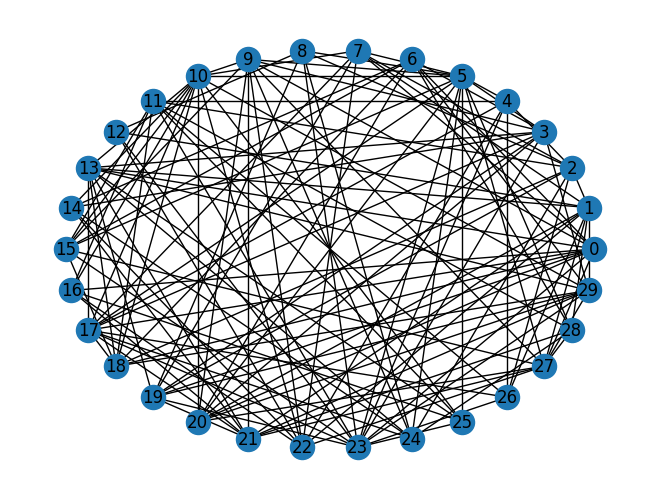

In [1]:
import baseGrafo

baseGrafo.grafoImport(30)

[7, 18, 19, 1, 4, 8, 11, 24, 26]


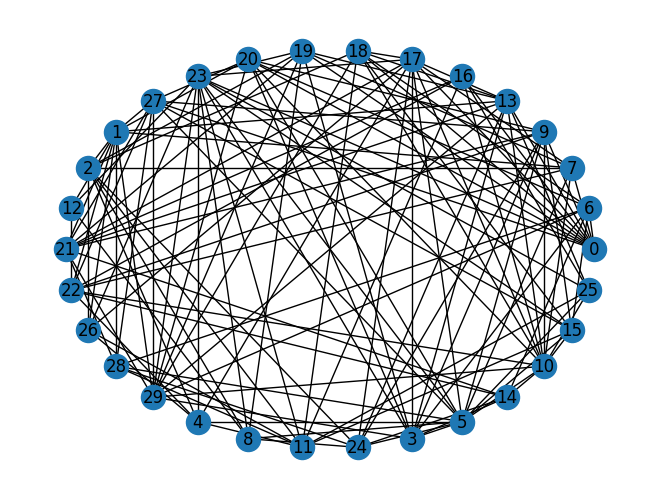

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import algorithmx
import pandas as pd
import baseGrafo
import random
import math



G = nx.read_edgelist("grafoBase2.csv", delimiter=",")
G = nx.relabel_nodes(G, lambda x: int(x))
print(list(G.neighbors(2)))

nx.draw_circular(G, with_labels=True)

In [21]:

def custo(coloring):
        # Conta o número de conflitos (nós adjacentes com mesma cor)
        conflitos = sum(1 for u, v in G.edges() if coloring[u] == coloring[v])
        return conflitos

def simulated_annealing_coloring(G, n_colors, max_iter=500000, i_temp=1000, cooling_rate=0.999):
    # Inicializa coloração aleatória
    coloring = {node: random.randint(0, n_colors-1) for node in G.nodes()}
    
    current_custo = custo(coloring)
    best_coloring = coloring.copy()
    best_custo = current_custo
    best_custo_i = current_custo
    temp = i_temp
    f_colors = n_colors
    flag = False
    
    for i in range(max_iter):
        node = random.choice(list(G.nodes()))
        old_color = coloring[node]
        nova_cor = random.randint(0, n_colors-1)
        coloring[node] = nova_cor
        
        new_custo = custo(coloring)

        dif = new_custo - current_custo
        
        if dif < 0 or random.random() < math.exp(-dif / temp):
            # Aceita nova solução
            current_custo = new_custo
            if new_custo < best_custo:
                best_coloring = coloring.copy()
                best_custo = new_custo
        else:
            # Reverte mudança
            coloring[node] = old_color
        
        # Atualiza temperatura
        temp *= cooling_rate

        # Opcional: parar se custo for 0 e tentar com menos cores(sem conflitos)
        if best_custo == 0 and i > 1500:
            best_coloring_i = coloring.copy()
            print("convergiu em 0, com", n_colors,"cores", "na iteracao", i)
            f_colors =  n_colors # qtd de cores de quando houve o encontro da resposta viavel
            n_colors -= 1
            best_custo_i = best_custo # numero de convergencia
            for node in coloring:
                if coloring[node] >= n_colors:
                    coloring[node] = random.randint(0, n_colors - 1)
            
            best_custo = custo(coloring)
            temp = i_temp
            current_custo = best_custo
            print("temperatura:", temp)
            flag = True

        elif best_custo == 0:
            best_custo_i = best_custo
            best_coloring_i = best_coloring
            f_colors = n_colors
            print(n_colors, i)
            break

        if i == max_iter-1 and flag == False:
            best_coloring_i = best_coloring
            best_custo_i = best_custo
            print("bateu o ponto")
            print("temperatura:", temp)
        

    return best_coloring_i, best_custo_i, f_colors

# Exemplo de uso
coloring, custo_final, cores= simulated_annealing_coloring(G, n_colors=6)

print('Coloração final:', coloring)
print(cores, 'cores')
print('Conflitos restantes:', custo_final)


convergiu em 0, com 6 cores na iteracao 8432
temperatura: 1000
convergiu em 0, com 5 cores na iteracao 17859
temperatura: 1000
Coloração final: {0: 3, 6: 4, 7: 2, 9: 1, 13: 2, 16: 2, 17: 1, 18: 0, 19: 0, 20: 2, 23: 4, 27: 4, 1: 0, 2: 4, 12: 2, 21: 3, 22: 3, 26: 3, 28: 2, 29: 1, 4: 2, 8: 1, 11: 1, 24: 3, 3: 3, 5: 0, 14: 2, 10: 4, 15: 2, 25: 3}
5 cores
Conflitos restantes: 0


bateu 0 e 16
bateu 0 e 17
bateu 0 e 23
bateu 6 e 3
bateu 9 e 5
bateu 9 e 20
bateu 13 e 1
bateu 13 e 10
bateu 17 e 23
bateu 17 e 24
bateu 18 e 2
bateu 19 e 3
bateu 19 e 21
bateu 20 e 5
bateu 23 e 15
bateu 23 e 29
bateu 27 e 1
bateu 2 e 4
bateu 2 e 26
bateu 12 e 8
bateu 26 e 4
bateu 28 e 5
bateu 4 e 5


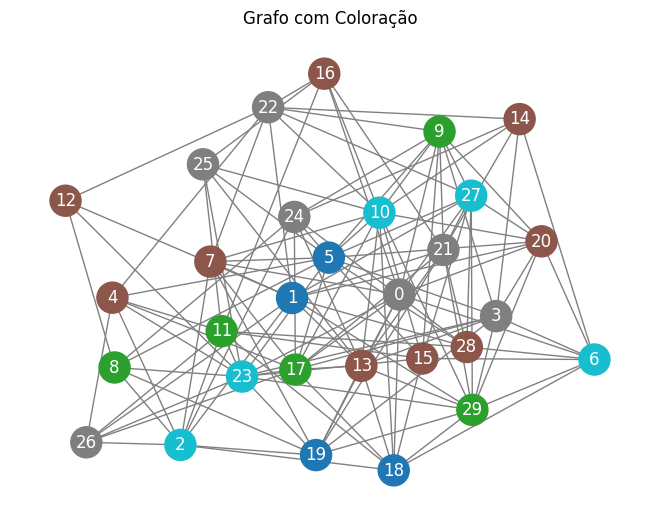

In [22]:
def desenhar_grafo_colorido(G, coloring):
    # Cria uma lista de cores para os nós com base na coloração fornecida
    node_colors = [coloring[node] for node in G.nodes()]
    for u, v in G.edges():
        if node_colors[u] == node_colors[v]:
            print("bateu", u ,"e", v)

    # Desenhar o grafo
    pos = nx.spring_layout(G, seed=42)  # layout bonito e fixo
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        cmap=plt.cm.tab10,  # até 10 cores distintas
        node_size=500,
        edge_color='gray',
        font_color='white'
    )
    plt.title("Grafo com Coloração")
    plt.show()

desenhar_grafo_colorido(G, coloring)



In [34]:
print(list(G.neighbors(3)))
print(coloring[3])
for node in G.nodes:
    if coloring[node] == 3:
        print(node,coloring[node])

[6, 9, 13, 17, 19, 20, 23, 29, 5, 14]
3
0 3
21 3
22 3
26 3
24 3
3 3
25 3
